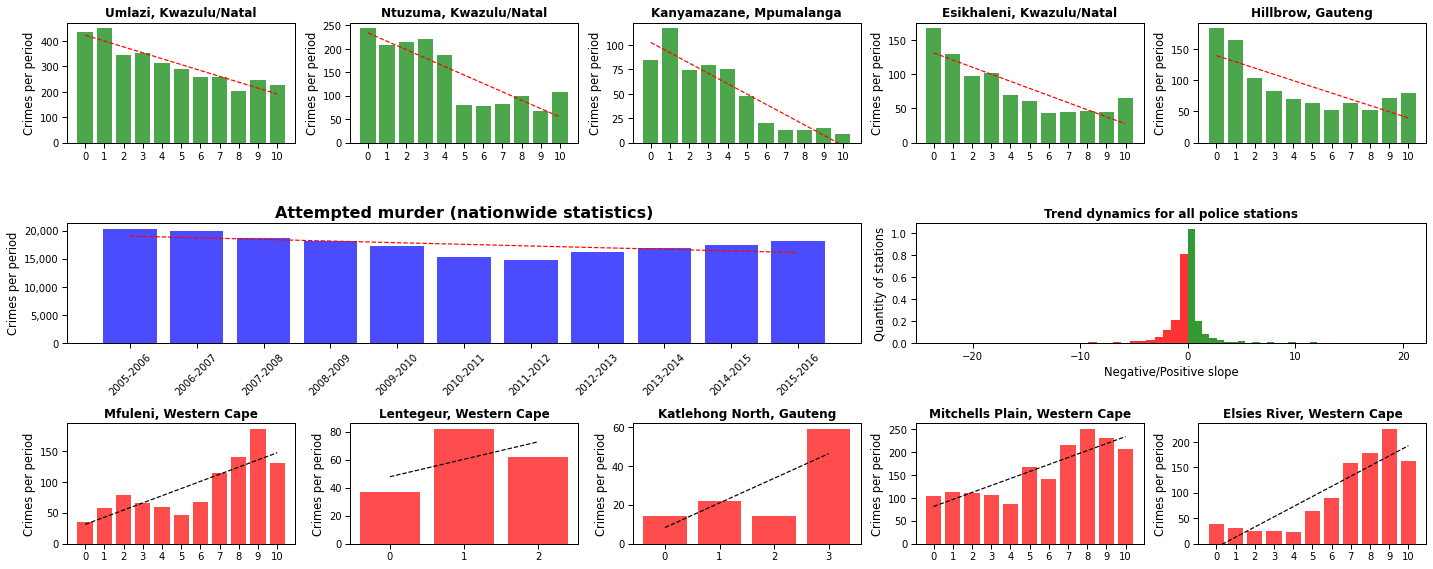

--------------------------------------------------------------------------
--------------------------------------------------------------------------


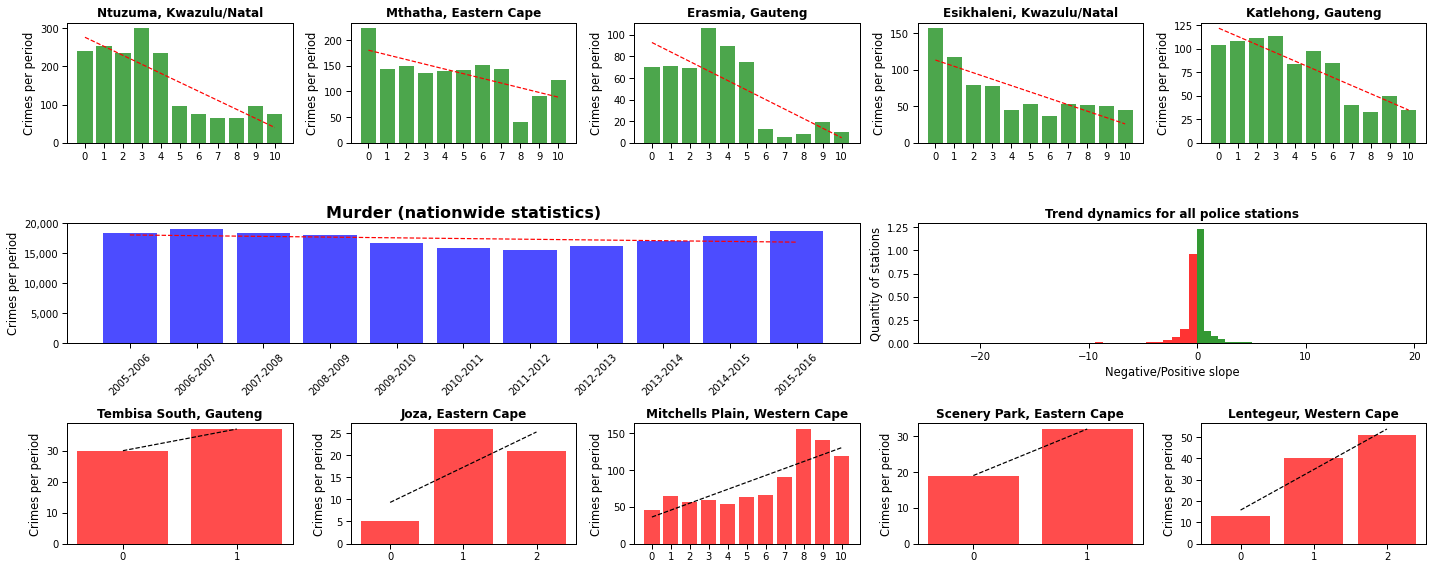

--------------------------------------------------------------------------
--------------------------------------------------------------------------


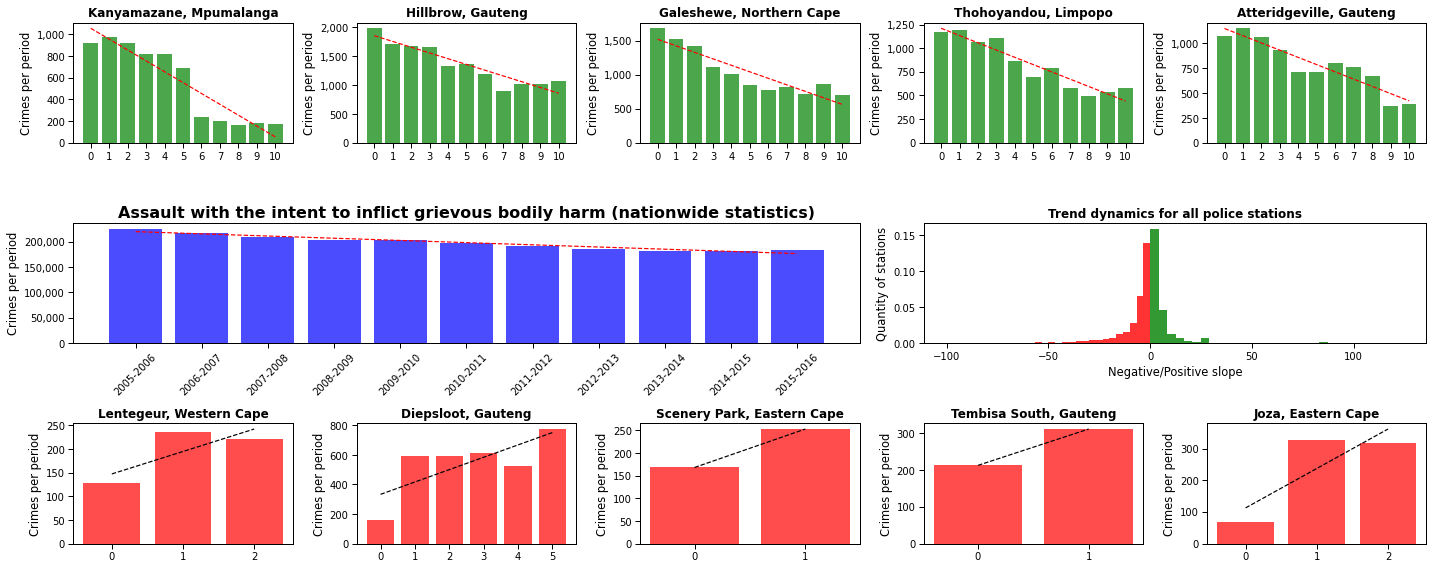

--------------------------------------------------------------------------
--------------------------------------------------------------------------


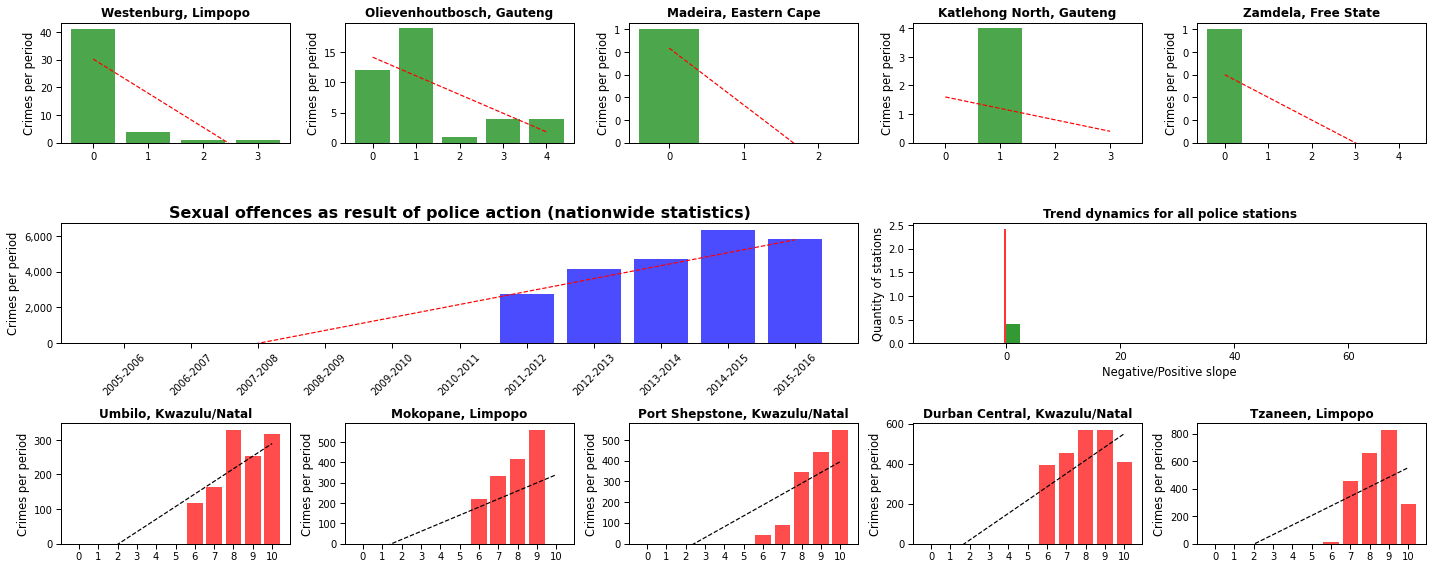

--------------------------------------------------------------------------
--------------------------------------------------------------------------


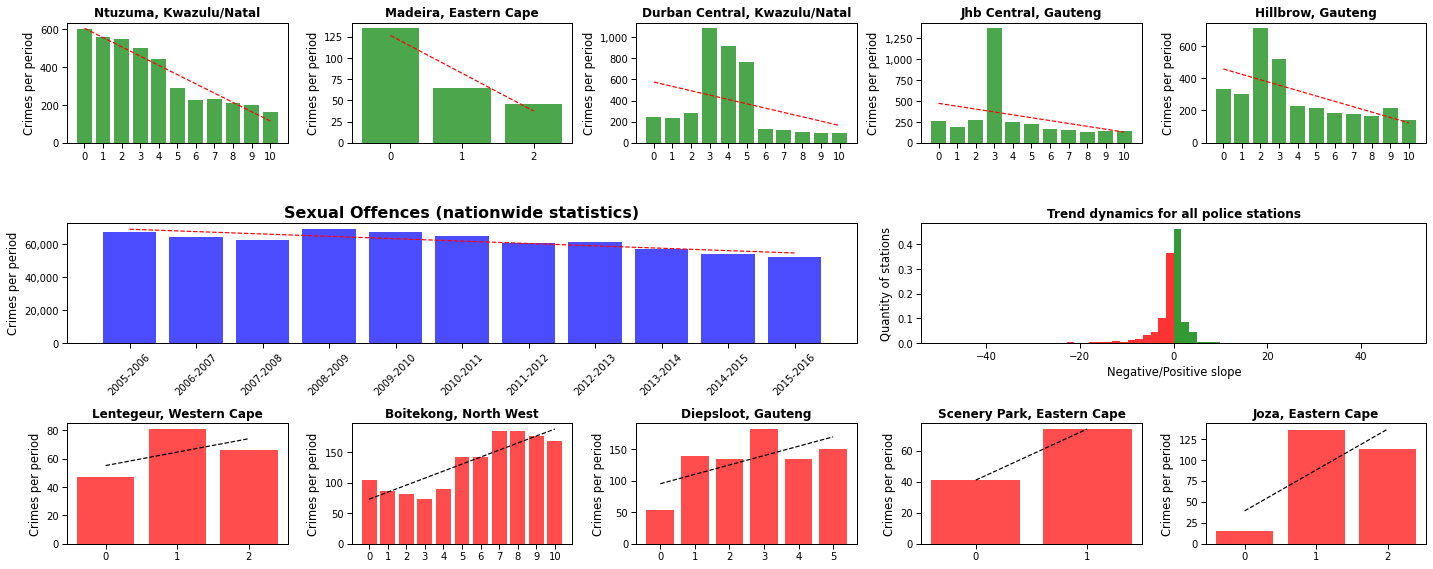

--------------------------------------------------------------------------
--------------------------------------------------------------------------


In [7]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
sns.set_style({'xtick.major.size': 0.5, 'ytick.major.size': 0.5})
sns.set_context("paper")
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10

# Import dataset ------------------------------------------------------------------- #
df = pd.read_csv('./Data/Crime/SouthAfricaCrimeStats_v2.csv')
sev_cat = ['Burglary at non-residential premises', 'Malicious damage to property',
           'Theft of motor vehicle and motorcycle', 'Carjacking', 'Attempted murder',
           'Burglary at residential premises', 'All theft not mentioned elsewhere',
           'Murder', 'Common assault', 'Truck hijacking',
           'Assault with the intent to inflict grievous bodily harm', 'Bank robbery',
           'Stock-theft', 'Robbery at non-residential premises',
           'Robbery with aggravating circumstances',
           'Driving under the influence of alcohol or drugs',
           'Theft out of or from motor vehicle', 'Drug-related crime',
           'Illegal possession of firearms and ammunition', 'Arson',
           'Robbery of cash in transit', 'Common robbery',
           'Robbery at residential premises',
           'Sexual offences as result of police action', 'Commercial crime',
           'Sexual Offences', 'Shoplifting']
sev_rate = [3, 3, 3, 3, 1, 3, 3, 1, 2, 3, 1, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 1, 3, 1, 3]
sev_df = pd.DataFrame({'Category':sev_cat, 'Severity':sev_rate})
df = df.merge(sev_df)
category_list = sorted(df['Category'].unique())
headings = list(df)
years = headings[3:-1]

# Identifying slope for each crime category (nationwide) ------------------------------------------------------------------- #
df_cat_sum = df[['Category']+years].groupby('Category').sum()
df_cat_sum_T = df_cat_sum.transpose()
slope_list = []
for i in category_list:
    coeff, residual = np.polyfit(range(0,len(years),1),df_cat_sum_T[i],1)
    slope_list+=[coeff]
df_cat_sum['Slope'] = slope_list

# Station appearance dictionary ------------------------------------------------------------------- #
df_station_sum = df[['Station']+years].groupby('Station').sum().reset_index()
st_list = sorted(df_station_sum['Station'].tolist())
station_appearance = {}
for x in st_list:
    index = np.nonzero(df_station_sum.loc[df_station_sum['Station']==x, years].values.flatten())[0][0]
    station_appearance[x]=index

st_list_new = []
for x in st_list:
    if station_appearance[x]==10:
        st_list_new += [x]
    else:
        st_list_new

# Get lists of crimes categories by severity ------------------------------------------------------------------- #
sev1 = sev_df.loc[sev_df['Severity']==1, "Category"].tolist()
sev2 = sev_df.loc[sev_df['Severity']==2, "Category"].tolist()
sev3 = sev_df.loc[sev_df['Severity']==3, "Category"].tolist()

# Visualization code ------------------------------------------------------------------- #
for i in sev1: # may be changed to "category_list" to include all crime categories
    # dynamic of specific crime category by police stations
    df_cat_station = df.loc[df['Category']==i,:]
    station_slope_list = []
    station_residual_list = []
    for n in st_list:
        if n not in st_list_new:
            coeff, residual = np.polyfit(range(station_appearance[n],len(years),1),df_cat_station.loc[df_cat_station['Station']==n,years[station_appearance[n]:]].values.flatten(),1)
        else:
            coeff, residual = 0,0
        station_slope_list+=[coeff] # fill in slope coefficient list
        station_residual_list+=[residual] # fill in residual list
    df_cat_station=df_cat_station.sort_values('Station',ascending=True)
    df_cat_station['Slope'] = station_slope_list # add slope to dataframe
    df_cat_station['Residual'] = station_residual_list # add residual to dataframe
    df_stat_asc = df_cat_station.sort_values('Slope', ascending=True)
    pd.DataFrame.to_csv(df_stat_asc,i+'.csv', index=None)

    # graph of country scale dynamic of specific crime category
    coeff_i, residual_i = np.polyfit(range(0,len(years),1),df_cat_sum_T[i],1)
    trend_line = [coeff_i*x + residual_i for x in range(df_cat_sum_T[i].shape[0])]
    x_pos = np.arange(len(years))
    crime_instances = df_cat_sum_T[i]
    fig = plt.figure(figsize=(20, 8))
    gs = gridspec.GridSpec(3, 5)
    ax1 = plt.subplot(gs[1,0:3])
    ax1.plot(x_pos, trend_line, color='red', linestyle='--')
    ax1.bar(x_pos, crime_instances, color = 'blue', alpha=0.7, align='center')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(years, rotation=45)
    ax1.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax1.set_ylabel('Crimes per period', size='large')
    ax1.set_title(i+' (nationwide statistics)', fontsize=16, fontweight='bold')
    ax1.set_ylim(ymin=0)
    ax2 = plt.subplot(gs[1,3:])
    ax2.hist(df_stat_asc.loc[df_stat_asc['Slope']<=0, 'Slope'],30, density=1, histtype='stepfilled', color='red', alpha=0.8)
    ax2.hist(df_stat_asc.loc[df_stat_asc['Slope']>0, 'Slope'],30, density=1, histtype='stepfilled', color='green', alpha=0.8)
    #ax2.spines['left'].set_position('zero')
    ax2.set_title("Trend dynamics for all police stations", fontsize=12, fontweight='bold')
    ax2.set_ylabel('Quantity of stations', size='large')
    ax2.set_xlabel('Negative/Positive slope', size='large')
    

    # set graphs of best performing police stations
    bsl = df_stat_asc[0:5]['Station'].tolist() # list of stations with best trend
    
    ax3 = plt.subplot(gs[0,0])
    ax4 = plt.subplot(gs[0,1])
    ax5 = plt.subplot(gs[0,2])
    ax6 = plt.subplot(gs[0,3])
    ax7 = plt.subplot(gs[0,4])

    dict_bs = {0:ax3, 1:ax4, 2:ax5, 3:ax6, 4:ax7}

    for m in range(0,5):    
        dict_bs[m] = plt.subplot(gs[0,m])
        trend_line_bs = [df_stat_asc.loc[df_stat_asc['Station']== bsl[m], 'Slope'].values*x 
                         + df_stat_asc.loc[df_stat_asc['Station']== bsl[m], 'Residual'].values 
                         for x in range(station_appearance[bsl[m]],len(years),1)] # trend line for selected station
        crime_instances_bs = df_stat_asc.loc[df_stat_asc['Station'] == bsl[m], years[station_appearance[bsl[m]]:]].values.flatten().tolist()
        x_pos_bs = np.arange(len(years[station_appearance[bsl[m]]:]))
        dict_bs[m].plot(x_pos_bs, trend_line_bs, color='red', linestyle='--')
        dict_bs[m].bar(x_pos_bs, crime_instances_bs, align='center', color = 'green', alpha=0.7)
        dict_bs[m].set_xticks(x_pos_bs)
        #dict_bs[m].set_xticklabels(['05-06','06-07','07-08','08-09','09-10','10-11','11-12','12-13','13-14','14-15','15-16'], fontsize=10, rotation=45)
        dict_bs[m].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        dict_bs[m].set_ylabel('Crimes per period', size='large')
        dict_bs[m].set_ylim(ymin=0)
        title = ', '.join(df_stat_asc.loc[df_stat_asc['Station']== bsl[m], ['Station','Province']].values.flatten().tolist())
        dict_bs[m].set_title(title, fontsize=12, fontweight='bold')


    # set graphs of worst performing police stations
    wsl = df_stat_asc[-5:]['Station'].tolist() # list of stations with worst trend
    
    ax8 = plt.subplot(gs[2,0])
    ax9 = plt.subplot(gs[2,1])
    ax10 = plt.subplot(gs[2,2])
    ax11 = plt.subplot(gs[2,3])
    ax12 = plt.subplot(gs[2,4])

    dict_ws = {0:ax8, 1:ax9, 2:ax10, 3:ax11, 4:ax12}

    for m in range(0,5):    
        dict_ws[m] = plt.subplot(gs[2,m])
        trend_line_ws = [df_stat_asc.loc[df_stat_asc['Station']== wsl[m], 'Slope'].values*x 
                         + df_stat_asc.loc[df_stat_asc['Station']== wsl[m], 'Residual'].values 
                         for x in range(station_appearance[wsl[m]],len(years),1)] # trend line for selected station
        crime_instances_ws = df_stat_asc.loc[df_stat_asc['Station'] == wsl[m], years[station_appearance[wsl[m]]:]].values.flatten().tolist()
        x_pos_ws = np.arange(len(years[station_appearance[wsl[m]]:]))
        dict_ws[m].plot(x_pos_ws, trend_line_ws, color='black', linestyle='--')
        dict_ws[m].bar(x_pos_ws, crime_instances_ws, align='center', color = 'red', alpha = 0.7)
        dict_ws[m].set_xticks(x_pos_ws)
        #dict_ws[m].set_xticklabels(['05-06','06-07','07-08','08-09','09-10','10-11','11-12','12-13','13-14','14-15','15-16'], fontsize=10, rotation=45)
        dict_ws[m].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        dict_ws[m].set_ylabel('Crimes per period', size='large')
        dict_ws[m].set_ylim(ymin=0)
        title = ', '.join(df_stat_asc.loc[df_stat_asc['Station']== wsl[m], ['Station','Province']].values.flatten().tolist())
        dict_ws[m].set_title(title, fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print ('--------------------------------------------------------------------------')
    print ('--------------------------------------------------------------------------') 